In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import csv
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class paths:
    fake_dir = '/kaggle/input/deep-fake-dataset/SDFVD/videos_fake/'
    real_dir = '/kaggle/input/deep-fake-dataset/SDFVD/videos_real/'

    data_dict = {}

    batch_size = 2
    learning_rate = 1e-3
    epoch = 10

In [4]:
fake_paths  = [os.path.join(paths.fake_dir, path) for path in os.listdir(paths.fake_dir)]
real_paths  = [os.path.join(paths.real_dir, path) for path in os.listdir(paths.real_dir)]

paths.data_dict.update({paths: 0 for paths in fake_paths })
paths.data_dict.update({paths: 1 for paths in  real_paths})

print(f'Total number of fake videos :{len(fake_paths)}')
print(f'Total number of real videos :{len(real_paths)}')

Total number of fake videos :53
Total number of real videos :53


In [5]:
for path, label in list(paths.data_dict.items())[:5]:
    print(f'Path: {path},  Label: {label}')

Path: /kaggle/input/deep-fake-dataset/SDFVD/videos_fake/vs8.mp4,  Label: 0
Path: /kaggle/input/deep-fake-dataset/SDFVD/videos_fake/vs44.mp4,  Label: 0
Path: /kaggle/input/deep-fake-dataset/SDFVD/videos_fake/vs5.mp4,  Label: 0
Path: /kaggle/input/deep-fake-dataset/SDFVD/videos_fake/vs11.mp4,  Label: 0
Path: /kaggle/input/deep-fake-dataset/SDFVD/videos_fake/vs20.mp4,  Label: 0


In [6]:
def crop_frame(frame):
    y,x = frame.shape[0:2]
    min_val = min(x,y)
    start_x = ( x//2 ) - ( min_val//2 )
    start_y = ( y//2 ) - ( min_val//2 )

    return frame[ start_y : start_y + min_val , start_x : start_x + min_val]

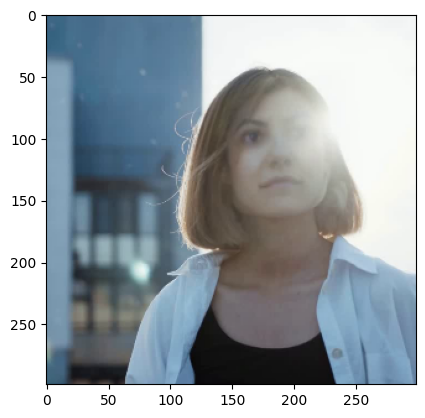

In [7]:
cap = cv2.VideoCapture(paths.fake_dir + 'vs11.mp4')
ret, frame = cap.read()
if ret:
    frame = crop_frame(frame)
    frame = cv2.resize(frame, (299,299))   
    frame = frame[:, :, (2,1,0)]
    
    plt.imshow(frame)
    plt.show()

In [8]:
def process_frames(frames, max_frames):
    
    if len(frames) >= max_frames:
        return frames[:max_frames]
        
    return frames + [frames[-1]] * (max_frames - len(frames))

In [9]:
from torchvision import models
from torchvision.models import Inception_V3_Weights
from torchsummary import summary

feature_extractor = models.inception_v3(weights = Inception_V3_Weights.DEFAULT).to(device)
feature_extractor.fc = torch.nn.Identity()
feature_extractor.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 243MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [10]:
class DeepfakeDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
      

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,idx):
        video_path = self.paths[idx]
        frames = []
        
        cap = cv2.VideoCapture(video_path)
        
        while True:
            ret, frame = cap.read()

            if not ret:
                break
                
            frame = crop_frame(frame) 
            frame = cv2.resize(frame, (299,299))   
            frame = frame[:, :, (2,1,0)].transpose(2,1,0)
            frames.append(frame)
            
        cap.release()

        frames = process_frames(frames, max_frames = 64)
        frames = np.array(frames)

        frames = torch.tensor(frames).to(device)
        
        features = feature_extractor(frames)

        return  features, torch.tensor(self.labels[idx]).to(device)
       

In [11]:
videos = list(paths.data_dict.keys())
labels = list(paths.data_dict.values())
print(len(videos))

106


In [12]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(videos, labels, test_size = 0.2, random_state = 42, shuffle = True)

In [13]:
train_dataset    = DeepfakeDataset(Xtrain, Ytrain)
train_dataloader = DataLoader(train_dataset , batch_size = paths.batch_size , shuffle = True)

test_dataset = DeepfakeDataset(Xtest, Ytest)
test_dataloader = DataLoader(test_dataset , batch_size = paths.batch_size , shuffle = True)

In [14]:
# Model
class DeepfakeGru(nn.Module):
    def __init__(self,input_size = 2048, hidden_size = 256, num_layers = 2,num_classes = 1):
        super(DeepfakeGru, self).__init__()
        self.gru = nn.GRU(input_size,hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self,x):
        _,hidden = self.gru(x)
        out = self.fc(hidden[-1])
        return out

In [17]:
model = DeepfakeGru()

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust initial LR
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
def precision(preds, targets):
    targets = targets.float()

    tp = (preds * targets).sum()
    fp = (preds * (1 - targets)).sum()

    precision = tp / (tp + fp + 1e-8)
    return precision.item()

In [19]:
def recall(preds, targets):
    targets = targets.float()

    tp = (preds * targets).sum()
    fn = ((1 - preds) * targets).sum()

    recall = tp / (tp + fn + 1e-8)
    return recall.item()

In [20]:
def perform_validation(model, test_dataloader, device):
    model.eval()  # Set model to evaluation mode
    val_loss, val_accuracy, val_precision, val_recall = 0, 0, 0, 0

    val_iterator = tqdm(test_dataloader, desc="Validation...", leave=False)
    with torch.no_grad():
        for inputs, labels in val_iterator:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Convert outputs to binary predictions
            predictions = torch.sigmoid(outputs) > 0.5

            # Move tensors to CPU and convert to NumPy
            labels_np = labels.cpu().numpy()
            predictions_np = predictions.cpu().numpy()

            # Compute metrics
            accuracy = accuracy_score(labels_np, predictions_np)
            precision = precision_score(labels_np, predictions_np, zero_division=1)
            recall = recall_score(labels_np, predictions_np, zero_division=1)

            val_loss += loss.item()
            val_accuracy += accuracy
            val_precision += precision
            val_recall += recall

    num_batches = len(test_dataloader)
    return (
        val_loss / num_batches,
        val_accuracy / num_batches,
        val_precision / num_batches,
        val_recall / num_batches
    )

In [21]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score
import csv
import time

model.to(device)

epochs = 10
best_accuracy = 0
total_training_time = 0
log_file = "Deepfake_299.csv"  
log_fields = ["epoch", "time", "train_loss", "val_loss", "accuracy_train", "accuracy_val", "precision_train", "precision_val", "recall_train", "recall_val"]

# Initialize logging file
with open(log_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=log_fields)
    writer.writeheader()

for epoch in range(epochs):
    model.train()
    start_time = time.time()

    train_loss = 0.0
    total_train_accuracy = 0
    total_train_precision = 0
    total_train_recall = 0

    with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}") as train_iterator:
        for i, (inputs, labels) in enumerate(train_iterator):
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

           
            predictions = torch.sigmoid(outputs) > 0.5

           
            labels_np = labels.cpu().numpy()
            predictions_np = predictions.cpu().numpy()

            
            train_accuracy_score = accuracy_score(labels_np, predictions_np)
            train_precision_score = precision_score(labels_np, predictions_np, zero_division=1)
            train_recall_score = recall_score(labels_np, predictions_np, zero_division=1)

           
            train_loss += loss.item()
            total_train_accuracy += train_accuracy_score
            total_train_precision += train_precision_score
            total_train_recall += train_recall_score

            train_iterator.set_postfix({
                'loss': f"{train_loss / (i + 1):.4f}",
                'accuracy': f"{total_train_accuracy / (i + 1):.4f}",
                'precision': f"{total_train_precision / (i + 1):.4f}",
                'recall': f"{total_train_recall / (i + 1):.4f}"
            })

    # Validation
    val_loss, val_accuracy, val_precision, val_recall = perform_validation(model, test_dataloader, device)

    scheduler.step(val_accuracy)

    # Save the best model
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'deepfake_299.pt')
        best_accuracy = val_accuracy

    epoch_time = time.time() - start_time
    total_training_time += epoch_time

    # Log metrics
    with open(log_file, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=log_fields)
        writer.writerow({
            "epoch": epoch,
            "time": epoch_time,
            "train_loss": train_loss / len(train_dataloader),
            "val_loss": val_loss,
            "accuracy_train": total_train_accuracy / len(train_dataloader),
            "accuracy_val": val_accuracy,
            "precision_train": total_train_precision / len(train_dataloader),
            "precision_val": val_precision,
            "recall_train": total_train_recall / len(train_dataloader),
            "recall_val": val_recall
        })

print(f"Training Complete in {total_training_time:.4f}s with {total_training_time/epochs:.4f}s per epoch.")


Epoch 10/10: 100%|██████████| 42/42 [00:58<00:00,  1.39s/it, loss=0.6983, accuracy=0.5000, precision=1.0000, recall=0.2857]
                                                              

Training Complete in 650.3459s with 65.0346s per epoch.
